In [1]:
%matplotlib inline

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_ml_long.ipynb)

[![View Source on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_ml_long.ipynb)

## HPO for machine learning models (long)

In [ ]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !pip install ai4water[hpo]

In [ ]:
import os
import math

import numpy as np

from ai4water import Model
from ai4water.datasets import MtropicsLaos
from ai4water.utils.utils import get_version_info
from ai4water.hyperopt import HyperOpt
from ai4water.preprocessing import DataSet
from ai4water.hyperopt import Categorical, Real, Integer
from ai4water.utils.utils import dateandtime_now, jsonize

from SeqMetrics import RegressionMetrics

In [3]:
for k,v in get_version_info().items():
    print(f"{k} version: {v}")

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os version: nt
ai4water version: 1.06
lightgbm version: 3.3.1
tcn version: 3.4.0
catboost version: 0.26
xgboost version: 1.5.0
easy_mpl version: 0.21.3
SeqMetrics version: 1.3.3
tensorflow version: 2.7.0
keras.api._v2.keras version: 2.7.0
numpy version: 1.21.0
pandas version: 1.3.4
matplotlib version: 3.4.3
h5py version: 3.5.0
sklearn version: 1.0.1
shapefile version: 2.3.0
xarray version: 0.20.1
netCDF4 version: 1.5.7
optuna version: 2.10.1
skopt version: 0.9.0
hyperopt version: 0.2.7
plotly version: 5.3.1
lime version: NotDefined
seaborn version: 0.11.2


In [4]:
# prepare the data

dataset = MtropicsLaos(path="F:\\data\\MtropicsLaos")
data = dataset.make_regression(lookback_steps=1)
print(data.shape)


    Not downloading the data since the directory 
    F:\data\MtropicsLaos already exists.
    Use overwrite=True to remove previously saved files and download again


Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


(258, 9)


In [5]:
input_features = data.columns.tolist()[0:-1]
print(input_features)

['air_temp', 'rel_hum', 'wind_speed', 'sol_rad', 'water_level', 'pcp', 'susp_pm', 'Ecoli_source']


In [6]:
output_features = data.columns.tolist()[-1:]
print(output_features)

['Ecoli_mpn100']


In [7]:
ds = DataSet(
    data=data,
    input_features=input_features,
    output_features=output_features,
    val_fraction = 0.0
)


In [8]:
TrainX, TrainY = ds.training_data()

***** Training *****
input_x shape:  (180, 8)
target shape:  (180, 1)


In [9]:
TestX, TestY = ds.test_data()

***** Test *****
input_x shape:  (78, 8)
target shape:  (78, 1)


In [10]:
model = Model(
    model = "RandomForestRegressor",
    input_features=input_features,
    output_features=output_features,
    x_transformation="zscore",
    y_transformation={"method": "log", "replace_zeros": True, "treat_negatives": True},
)


            building ML model for  
            regression problem using RandomForestRegressor


In [11]:
_ = model.fit(x=TrainX, y=TrainY)

In [12]:
model.evaluate(x=TrainX, y=TrainY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.8647780202076567,
 'nse': 0.7661250030324341,
 'rmse': 5083.421664938254}

In [13]:
model.evaluate(x=TestX, y=TestY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.3029087206809293,
 'nse': 0.20634949505073052,
 'rmse': 23327.364035828545}

In [14]:
from ai4water.utils import TrainTestSplit
spliter = TrainTestSplit()
train_x, val_x, train_y, val_y = spliter.split_by_slicing(TrainX, TrainY)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((125, 8), (55, 8), (125, 1), (55, 1))

In [15]:
# housekeeping

PREFIX = f"hpo_{dateandtime_now()}"  # folder name where to save the results
ITER = 0  # iteration counter
SEP = os.sep

In [16]:
num_iterations = 150  # number of hyperparameter iterations

In [17]:
VAL_SCORES = []
ITER = 0

def objective_fn(
    prefix=None,
    fit_on_all_data: bool = False,
    return_model: bool = False,
    **suggestions
)->float:
    """
    This function must build, train and evaluate the ML model.
    The output of this function will be minimized by optimization algorithm.
    """
    suggestions = jsonize(suggestions)
    global ITER

    # build model
    _model = Model(
        model={"RandomForestRegressor": suggestions},
        input_features=input_features,
        output_features=output_features,
        x_transformation="zscore",
        y_transformation={"method": "log", "replace_zeros": True, "treat_negatives": True},
        prefix=prefix or PREFIX,
        verbosity=0,
    )

    # train model
    
    if fit_on_all_data:
        _model.fit(x=TrainX, y=TrainY)
    else:
        _model.fit(x=train_x, y=train_y)

    # evaluate model
    val_p = _model.predict(x=val_x)
    val_score_ = RegressionMetrics(val_y, val_p).r2_score()
    

    
    if not math.isfinite(val_score_):
        val_score_ = -9999

    # since the optimization algorithm solves minimization algorithm
    # we have to subtract r2_score from 1.0
    # if our validation metric is something like mse or rmse,
    # then we don't need to subtract it from 1.0
    val_score = 1.0 - val_score_

    VAL_SCORES.append(val_score)
    best_score = round(np.nanmin(VAL_SCORES), 2)
    bst_iter = np.argmin(VAL_SCORES)
    
    ITER += 1

    print(f"{ITER} {round(val_score, 2)} {round(val_score_, 2)}. Best was {best_score} at {bst_iter}")

    if return_model:
        return _model
    
    return val_score

parameter space

In [18]:
param_space = [
    Integer(low=5, high=100, name='n_estimators', num_samples=10),
    Integer(low=2, high=30, prior='log', name='max_leaf_nodes', num_samples=10),
    Real(low=0.0, high=0.5, name='min_weight_fraction_leaf', num_samples=10),
    Integer(low=2, high=10, name='max_depth', num_samples=10),
    Integer(low=2, high=10, name='min_samples_split', num_samples=10),
    Integer(low=1, high=5, name='min_samples_leaf', num_samples=10)
]
            

In [19]:
x0 = [100, 2, 0.0, 10, 2, 1]

In [20]:
optimizer = HyperOpt(
    algorithm="bayes",
    objective_fn=objective_fn,
    param_space=param_space,
    x0=x0,
    num_iterations=num_iterations,
    process_results=False,  # we can turn it False if we want post-processing of results
    opt_path=f"results{SEP}{PREFIX}"
)

In [21]:
results = optimizer.fit()

1 1.31 -0.31. Best was 1.31 at 0
2 1.33 -0.33. Best was 1.31 at 0
3 1.33 -0.33. Best was 1.31 at 0
4 1.33 -0.33. Best was 1.31 at 0
5 1.24 -0.24. Best was 1.24 at 4
6 1.25 -0.25. Best was 1.24 at 4
7 1.32 -0.32. Best was 1.24 at 4
8 1.31 -0.31. Best was 1.24 at 4
9 1.21 -0.21. Best was 1.21 at 8
10 1.25 -0.25. Best was 1.21 at 8
11 1.27 -0.27. Best was 1.21 at 8
12 1.21 -0.21. Best was 1.21 at 8
13 1.19 -0.19. Best was 1.19 at 12
14 1.2 -0.2. Best was 1.19 at 12
15 1.2 -0.2. Best was 1.19 at 12
16 1.38 -0.38. Best was 1.19 at 12
17 1.19 -0.19. Best was 1.19 at 12
18 1.22 -0.22. Best was 1.19 at 12
19 1.19 -0.19. Best was 1.19 at 12
20 1.2 -0.2. Best was 1.19 at 12
21 1.17 -0.17. Best was 1.17 at 20
22 1.19 -0.19. Best was 1.17 at 20
23 1.01 -0.01. Best was 1.01 at 22
24 1.31 -0.31. Best was 1.01 at 22
25 1.26 -0.26. Best was 1.01 at 22
26 1.1 -0.1. Best was 1.01 at 22
27 1.01 -0.01. Best was 1.01 at 26
28 1.01 -0.01. Best was 1.01 at 26
29 1.01 -0.01. Best was 1.01 at 26
30 1.02 -0.02.

The objective has been evaluated at this point before.


45 1.01 -0.01. Best was 1.01 at 26
46 1.19 -0.19. Best was 1.01 at 26
47 1.01 -0.01. Best was 1.01 at 26
48 1.01 -0.01. Best was 1.01 at 26
49 1.07 -0.07. Best was 1.01 at 26
50 1.08 -0.08. Best was 1.01 at 26
51 1.12 -0.12. Best was 1.01 at 26
52 1.01 -0.01. Best was 1.01 at 51
53 1.01 -0.01. Best was 1.01 at 51
54 1.01 -0.01. Best was 1.01 at 51
55 1.08 -0.08. Best was 1.01 at 51
56 1.07 -0.07. Best was 1.01 at 51
57 1.06 -0.06. Best was 1.01 at 51
58 0.98 0.02. Best was 0.98 at 57
59 0.99 0.01. Best was 0.98 at 57
60 1.01 -0.01. Best was 0.98 at 57
61 1.31 -0.31. Best was 0.98 at 57
62 0.99 0.01. Best was 0.98 at 57
63 1.03 -0.03. Best was 0.98 at 57


The objective has been evaluated at this point before.


64 0.99 0.01. Best was 0.98 at 57
65 1.38 -0.38. Best was 0.98 at 57
66 1.33 -0.33. Best was 0.98 at 57


The objective has been evaluated at this point before.


67 0.99 0.01. Best was 0.98 at 57
68 1.01 -0.01. Best was 0.98 at 57
69 1.06 -0.06. Best was 0.98 at 57
70 0.98 0.02. Best was 0.98 at 69
71 1.0 -0.0. Best was 0.98 at 69
72 0.97 0.03. Best was 0.97 at 71
73 0.96 0.04. Best was 0.96 at 72
74 0.96 0.04. Best was 0.96 at 72
75 1.05 -0.05. Best was 0.96 at 72


The objective has been evaluated at this point before.


76 0.97 0.03. Best was 0.96 at 72


The objective has been evaluated at this point before.


77 0.96 0.04. Best was 0.96 at 72


The objective has been evaluated at this point before.


78 0.96 0.04. Best was 0.96 at 72
79 0.96 0.04. Best was 0.96 at 78
80 0.96 0.04. Best was 0.96 at 78
81 0.95 0.05. Best was 0.95 at 80
82 1.0 -0.0. Best was 0.95 at 80
83 0.97 0.03. Best was 0.95 at 80
84 1.03 -0.03. Best was 0.95 at 80
85 0.97 0.03. Best was 0.95 at 80
86 1.3 -0.3. Best was 0.95 at 80
87 0.95 0.05. Best was 0.95 at 86
88 1.38 -0.38. Best was 0.95 at 86
89 0.95 0.05. Best was 0.95 at 88


The objective has been evaluated at this point before.


90 0.95 0.05. Best was 0.95 at 88
91 1.1 -0.1. Best was 0.95 at 88
92 0.95 0.05. Best was 0.95 at 88
93 0.98 0.02. Best was 0.95 at 88
94 0.96 0.04. Best was 0.95 at 88


The objective has been evaluated at this point before.


95 0.95 0.05. Best was 0.95 at 88
96 1.01 -0.01. Best was 0.95 at 88
97 0.95 0.05. Best was 0.95 at 96
98 1.07 -0.07. Best was 0.95 at 96
99 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


100 0.95 0.05. Best was 0.95 at 98
101 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


102 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


103 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


104 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


105 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


106 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


107 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


108 0.95 0.05. Best was 0.95 at 98
109 1.01 -0.01. Best was 0.95 at 98
110 1.01 -0.01. Best was 0.95 at 98
111 0.99 0.01. Best was 0.95 at 98
112 1.08 -0.08. Best was 0.95 at 98
113 1.0 -0.0. Best was 0.95 at 98
114 1.24 -0.24. Best was 0.95 at 98
115 1.01 -0.01. Best was 0.95 at 98
116 1.03 -0.03. Best was 0.95 at 98
117 1.01 -0.01. Best was 0.95 at 98


The objective has been evaluated at this point before.


118 0.95 0.05. Best was 0.95 at 98
119 1.03 -0.03. Best was 0.95 at 98
120 1.01 -0.01. Best was 0.95 at 98
121 1.0 -0.0. Best was 0.95 at 98
122 1.0 -0.0. Best was 0.95 at 98


The objective has been evaluated at this point before.


123 0.95 0.05. Best was 0.95 at 98
124 1.0 -0.0. Best was 0.95 at 98


The objective has been evaluated at this point before.


125 0.95 0.05. Best was 0.95 at 98
126 1.01 -0.01. Best was 0.95 at 98
127 0.98 0.02. Best was 0.95 at 98
128 0.96 0.04. Best was 0.95 at 98


The objective has been evaluated at this point before.


129 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


130 0.95 0.05. Best was 0.95 at 98
131 1.01 -0.01. Best was 0.95 at 98


The objective has been evaluated at this point before.


132 0.95 0.05. Best was 0.95 at 98
133 1.01 -0.01. Best was 0.95 at 98


The objective has been evaluated at this point before.


134 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


135 0.95 0.05. Best was 0.95 at 98
136 1.31 -0.31. Best was 0.95 at 98
137 1.0 -0.0. Best was 0.95 at 98
138 1.04 -0.04. Best was 0.95 at 98
139 1.38 -0.38. Best was 0.95 at 98
140 1.01 -0.01. Best was 0.95 at 98
141 1.01 -0.01. Best was 0.95 at 98


The objective has been evaluated at this point before.


142 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


143 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


144 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


145 0.95 0.05. Best was 0.95 at 98


The objective has been evaluated at this point before.


146 0.95 0.05. Best was 0.95 at 98
147 1.1 -0.1. Best was 0.95 at 98


The objective has been evaluated at this point before.


148 0.95 0.05. Best was 0.95 at 98
149 1.17 -0.17. Best was 0.95 at 98
150 1.3 -0.3. Best was 0.95 at 98


In [22]:
optimizer.best_iter()

98

In [23]:
optimizer.best_paras()

{'n_estimators': 86,
 'max_leaf_nodes': 27,
 'min_weight_fraction_leaf': 0.0,
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

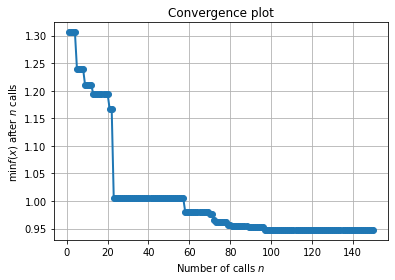

In [24]:
_ = optimizer._plot_convergence()

In [25]:
model = objective_fn(prefix=f"{PREFIX}{SEP}best", 
                     return_model=True, 
                     fit_on_all_data=True,
                     **optimizer.best_paras())

151 0.32 0.68. Best was 0.32 at 150


In [26]:
model.evaluate(x=TrainX, y=TrainY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.7516958618455171, 'nse': 0.636805383838632, 'rmse': 6334.81503965959}

In [27]:
model.evaluate(x=TestX, y=TestY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.32823991738528224,
 'nse': 0.19824288799447032,
 'rmse': 23446.198035299272}

In [28]:
VAL_SCORES = []
ITER = 0

def objective_fn(
    prefix=None,
    fit_on_all_data: bool = False,
    return_model: bool = False,
    **suggestions
)->float:
    """
    This function must build, train and evaluate the ML model.
    The output of this function will be minimized by optimization algorithm.
    """
    suggestions = jsonize(suggestions)

    global ITER

    # build model
    
    _model = Model(
        model={"RandomForestRegressor": suggestions},
        input_features=input_features,
        output_features=output_features,
        x_transformation="zscore",
        y_transformation={"method": "log", "replace_zeros": True, "treat_negatives": True},
        cross_validator = {"TimeSeriesSplit": {"n_splits": 5}},
        prefix=prefix or PREFIX,
        verbosity=0,
    )

    # train model
    
    if fit_on_all_data:
        _model.fit(x=TrainX, y=TrainY)
        val_score_ = _model.evaluate(x=TestX, y=TestY, metrics="r2_score")
    else:
        cv_scores = _model.cross_val_score(x=TrainX, y=TrainY, scoring="r2_score")
        val_score_ = np.mean(cv_scores)


    if not math.isfinite(val_score_):
        val_score_ = -9999

    # since the optimization algorithm solves minimization algorithm
    # we have to subtract r2_score from 1.0
    # if our validation metric is something like mse or rmse,
    # then we don't need to subtract it from 1.0
    val_score = 1.0 - val_score_
    VAL_SCORES.append(val_score)
    best_score = round(np.nanmin(VAL_SCORES), 2)
    bst_iter = np.argmin(VAL_SCORES)

    ITER += 1

    print(f"{ITER} {round(val_score, 2)} {round(val_score_, 2)}. Best was {best_score} at {bst_iter}")

    if return_model:
        return _model
    
    return val_score


In [29]:
optimizer = HyperOpt(
    algorithm="random",
    backend="optuna",
    objective_fn=objective_fn,
    param_space=param_space,
    x0=x0,
    num_iterations=num_iterations,
    process_results=False,  # we can turn it False if we want post-processing of results
    opt_path=f"results{SEP}{PREFIX}"
)

In [30]:
results = optimizer.fit()

[I 2023-02-07 16:11:03,350] A new study created in memory with name: no-name-458b9411-2837-4dd9-b899-d32545e6c0e9
[I 2023-02-07 16:11:04,135] Trial 0 finished with value: 1.1775380935578639 and parameters: {'n_estimators': 98, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.13627664120452787, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.1775380935578639.


1 1.18 -0.18. Best was 1.18 at 0


[I 2023-02-07 16:11:04,441] Trial 1 finished with value: 1.2012473519634588 and parameters: {'n_estimators': 8, 'max_leaf_nodes': 10, 'min_weight_fraction_leaf': 0.41415318234874765, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.1775380935578639.


2 1.2 -0.2. Best was 1.18 at 0


[I 2023-02-07 16:11:05,035] Trial 2 finished with value: 1.1701517864949043 and parameters: {'n_estimators': 60, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.1526542646820337, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.1701517864949043.


3 1.17 -0.17. Best was 1.17 at 2


[I 2023-02-07 16:11:05,919] Trial 3 finished with value: 1.1962737111297534 and parameters: {'n_estimators': 96, 'max_leaf_nodes': 20, 'min_weight_fraction_leaf': 0.3113809069877246, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.1701517864949043.


4 1.2 -0.2. Best was 1.17 at 2


[I 2023-02-07 16:11:06,313] Trial 4 finished with value: 1.2025415530941976 and parameters: {'n_estimators': 26, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.400943347182733, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 1.1701517864949043.


5 1.2 -0.2. Best was 1.17 at 2


[I 2023-02-07 16:11:06,623] Trial 5 finished with value: 1.187021119024901 and parameters: {'n_estimators': 9, 'max_leaf_nodes': 19, 'min_weight_fraction_leaf': 0.2581755714494389, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.1701517864949043.


6 1.19 -0.19. Best was 1.17 at 2


[I 2023-02-07 16:11:07,320] Trial 6 finished with value: 1.186918204062007 and parameters: {'n_estimators': 82, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.2547304566262614, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.1701517864949043.


7 1.19 -0.19. Best was 1.17 at 2


[I 2023-02-07 16:11:07,869] Trial 7 finished with value: 1.1883786121858053 and parameters: {'n_estimators': 54, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.2675913998096921, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.1701517864949043.


8 1.19 -0.19. Best was 1.17 at 2


[I 2023-02-07 16:11:08,322] Trial 8 finished with value: 1.1420448163536452 and parameters: {'n_estimators': 35, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.11313907861444905, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 8 with value: 1.1420448163536452.


9 1.14 -0.14. Best was 1.14 at 8


[I 2023-02-07 16:11:08,820] Trial 9 finished with value: 1.1810292869431283 and parameters: {'n_estimators': 44, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.25348476232289463, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 8 with value: 1.1420448163536452.


10 1.18 -0.18. Best was 1.14 at 8


[I 2023-02-07 16:11:09,474] Trial 10 finished with value: 1.181052516800856 and parameters: {'n_estimators': 72, 'max_leaf_nodes': 24, 'min_weight_fraction_leaf': 0.20628187307669738, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 8 with value: 1.1420448163536452.


11 1.18 -0.18. Best was 1.14 at 8


[I 2023-02-07 16:11:09,833] Trial 11 finished with value: 1.1558594423780515 and parameters: {'n_estimators': 18, 'max_leaf_nodes': 22, 'min_weight_fraction_leaf': 0.1309302083664763, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 8 with value: 1.1420448163536452.


12 1.16 -0.16. Best was 1.14 at 8


[I 2023-02-07 16:11:10,260] Trial 12 finished with value: 1.1739464975016032 and parameters: {'n_estimators': 31, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.22737778600160163, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 8 with value: 1.1420448163536452.


13 1.17 -0.17. Best was 1.14 at 8


[I 2023-02-07 16:11:10,833] Trial 13 finished with value: 1.1395759167763093 and parameters: {'n_estimators': 56, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.10530649621535504, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 1.1395759167763093.


14 1.14 -0.14. Best was 1.14 at 13


[I 2023-02-07 16:11:11,214] Trial 14 finished with value: 1.158843376164459 and parameters: {'n_estimators': 22, 'max_leaf_nodes': 26, 'min_weight_fraction_leaf': 0.1695891571175045, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 13 with value: 1.1395759167763093.


15 1.16 -0.16. Best was 1.14 at 13


[I 2023-02-07 16:11:11,569] Trial 15 finished with value: 1.193477547745503 and parameters: {'n_estimators': 18, 'max_leaf_nodes': 14, 'min_weight_fraction_leaf': 0.44352622450495255, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


16 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:12,363] Trial 16 finished with value: 1.192733433610853 and parameters: {'n_estimators': 97, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.45827754993947756, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 13 with value: 1.1395759167763093.


17 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:13,030] Trial 17 finished with value: 1.1974703469710506 and parameters: {'n_estimators': 70, 'max_leaf_nodes': 27, 'min_weight_fraction_leaf': 0.32714611514424147, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


18 1.2 -0.2. Best was 1.14 at 13


[I 2023-02-07 16:11:13,601] Trial 18 finished with value: 1.1930313229968088 and parameters: {'n_estimators': 56, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.43445255174981706, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 13 with value: 1.1395759167763093.


19 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:13,950] Trial 19 finished with value: 1.1710189776217488 and parameters: {'n_estimators': 17, 'max_leaf_nodes': 22, 'min_weight_fraction_leaf': 0.22273892498550957, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 13 with value: 1.1395759167763093.


20 1.17 -0.17. Best was 1.14 at 13


[I 2023-02-07 16:11:14,577] Trial 20 finished with value: 1.183251822526263 and parameters: {'n_estimators': 67, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.19151823734659246, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


21 1.18 -0.18. Best was 1.14 at 13


[I 2023-02-07 16:11:15,013] Trial 21 finished with value: 1.1855162658036287 and parameters: {'n_estimators': 33, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.3098048606791657, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 13 with value: 1.1395759167763093.


22 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:15,358] Trial 22 finished with value: 1.1985322018993438 and parameters: {'n_estimators': 16, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.37354497455949864, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 13 with value: 1.1395759167763093.


23 1.2 -0.2. Best was 1.14 at 13


[I 2023-02-07 16:11:15,930] Trial 23 finished with value: 1.197031634284733 and parameters: {'n_estimators': 60, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.02355822705678684, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


24 1.2 -0.2. Best was 1.14 at 13


[I 2023-02-07 16:11:16,228] Trial 24 finished with value: 1.1937247160877884 and parameters: {'n_estimators': 8, 'max_leaf_nodes': 16, 'min_weight_fraction_leaf': 0.24974023567589482, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 13 with value: 1.1395759167763093.


25 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:16,700] Trial 25 finished with value: 1.189717858587465 and parameters: {'n_estimators': 40, 'max_leaf_nodes': 25, 'min_weight_fraction_leaf': 0.44388213287811246, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 13 with value: 1.1395759167763093.


26 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:17,488] Trial 26 finished with value: 1.169676742392852 and parameters: {'n_estimators': 96, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.16492136731731433, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


27 1.17 -0.17. Best was 1.14 at 13


[I 2023-02-07 16:11:17,864] Trial 27 finished with value: 1.1848220948875097 and parameters: {'n_estimators': 21, 'max_leaf_nodes': 30, 'min_weight_fraction_leaf': 0.3000371931320479, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 13 with value: 1.1395759167763093.


28 1.18 -0.18. Best was 1.14 at 13


[I 2023-02-07 16:11:18,377] Trial 28 finished with value: 1.1952494243099299 and parameters: {'n_estimators': 45, 'max_leaf_nodes': 11, 'min_weight_fraction_leaf': 0.4088953210894375, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 1.1395759167763093.


29 1.2 -0.2. Best was 1.14 at 13


[I 2023-02-07 16:11:18,964] Trial 29 finished with value: 1.191084504269142 and parameters: {'n_estimators': 57, 'max_leaf_nodes': 20, 'min_weight_fraction_leaf': 0.47540634648796526, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 13 with value: 1.1395759167763093.


30 1.19 -0.19. Best was 1.14 at 13


[I 2023-02-07 16:11:19,515] Trial 30 finished with value: 1.1164274676869697 and parameters: {'n_estimators': 49, 'max_leaf_nodes': 26, 'min_weight_fraction_leaf': 0.003797422636341863, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 30 with value: 1.1164274676869697.


31 1.12 -0.12. Best was 1.12 at 30


[I 2023-02-07 16:11:20,096] Trial 31 finished with value: 1.1953882224708487 and parameters: {'n_estimators': 56, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.28855600985967533, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 30 with value: 1.1164274676869697.


32 1.2 -0.2. Best was 1.12 at 30


[I 2023-02-07 16:11:20,799] Trial 32 finished with value: 1.153866187189525 and parameters: {'n_estimators': 50, 'max_leaf_nodes': 10, 'min_weight_fraction_leaf': 0.1309504435564296, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 30 with value: 1.1164274676869697.


33 1.15 -0.15. Best was 1.12 at 30


[I 2023-02-07 16:11:21,215] Trial 33 finished with value: 1.1678097492623234 and parameters: {'n_estimators': 28, 'max_leaf_nodes': 16, 'min_weight_fraction_leaf': 0.19601054340047874, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 30 with value: 1.1164274676869697.


34 1.17 -0.17. Best was 1.12 at 30


[I 2023-02-07 16:11:21,894] Trial 34 finished with value: 1.1930705313838175 and parameters: {'n_estimators': 77, 'max_leaf_nodes': 24, 'min_weight_fraction_leaf': 0.4820488396582929, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 30 with value: 1.1164274676869697.


35 1.19 -0.19. Best was 1.12 at 30


[I 2023-02-07 16:11:22,537] Trial 35 finished with value: 1.1415858164458466 and parameters: {'n_estimators': 68, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.09787620468776809, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 30 with value: 1.1164274676869697.


36 1.14 -0.14. Best was 1.12 at 30


[I 2023-02-07 16:11:22,847] Trial 36 finished with value: 1.1666877298920169 and parameters: {'n_estimators': 7, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.12527486828403467, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 30 with value: 1.1164274676869697.


37 1.17 -0.17. Best was 1.12 at 30


[I 2023-02-07 16:11:23,288] Trial 37 finished with value: 1.1618220743801 and parameters: {'n_estimators': 31, 'max_leaf_nodes': 16, 'min_weight_fraction_leaf': 0.17710726836806884, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 30 with value: 1.1164274676869697.


38 1.16 -0.16. Best was 1.12 at 30


[I 2023-02-07 16:11:23,978] Trial 38 finished with value: 1.1990507167518172 and parameters: {'n_estimators': 77, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.3088472472035437, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 30 with value: 1.1164274676869697.


39 1.2 -0.2. Best was 1.12 at 30


[I 2023-02-07 16:11:24,491] Trial 39 finished with value: 1.0859111149000562 and parameters: {'n_estimators': 40, 'max_leaf_nodes': 15, 'min_weight_fraction_leaf': 0.01191487491325044, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


40 1.09 -0.09. Best was 1.09 at 39


[I 2023-02-07 16:11:24,884] Trial 40 finished with value: 1.1921970066056413 and parameters: {'n_estimators': 22, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.4287609896869012, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


41 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:25,356] Trial 41 finished with value: 1.187777396470399 and parameters: {'n_estimators': 36, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.4830352418192002, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


42 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:25,862] Trial 42 finished with value: 1.1933751376353379 and parameters: {'n_estimators': 45, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.32635384586925564, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


43 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:26,202] Trial 43 finished with value: 1.196638676320197 and parameters: {'n_estimators': 15, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.38791847770240495, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


44 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:26,858] Trial 44 finished with value: 1.162876241191274 and parameters: {'n_estimators': 69, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.13144670865255947, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


45 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:11:27,412] Trial 45 finished with value: 1.1182404538925996 and parameters: {'n_estimators': 50, 'max_leaf_nodes': 19, 'min_weight_fraction_leaf': 0.06185116621821546, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


46 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:11:27,783] Trial 46 finished with value: 1.1753745364160244 and parameters: {'n_estimators': 19, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.2907650699212052, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


47 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:28,275] Trial 47 finished with value: 1.1787168777951753 and parameters: {'n_estimators': 42, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.2391035194438016, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


48 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:28,777] Trial 48 finished with value: 1.1947655370158958 and parameters: {'n_estimators': 46, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.3780627076063192, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


49 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:29,227] Trial 49 finished with value: 1.1900616856302224 and parameters: {'n_estimators': 37, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.4442430735063028, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


50 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:29,677] Trial 50 finished with value: 1.1306912551568409 and parameters: {'n_estimators': 33, 'max_leaf_nodes': 19, 'min_weight_fraction_leaf': 0.08372014916997017, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


51 1.13 -0.13. Best was 1.09 at 39


[I 2023-02-07 16:11:30,350] Trial 51 finished with value: 1.1737184061675139 and parameters: {'n_estimators': 77, 'max_leaf_nodes': 26, 'min_weight_fraction_leaf': 0.16412586984957706, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


52 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:11:30,968] Trial 52 finished with value: 1.1676440225162386 and parameters: {'n_estimators': 60, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.15869613677732874, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


53 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:11:31,597] Trial 53 finished with value: 1.19237162094292 and parameters: {'n_estimators': 71, 'max_leaf_nodes': 29, 'min_weight_fraction_leaf': 0.49704917995059356, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


54 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:32,285] Trial 54 finished with value: 1.181789224423309 and parameters: {'n_estimators': 82, 'max_leaf_nodes': 26, 'min_weight_fraction_leaf': 0.23673851829931347, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


55 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:32,812] Trial 55 finished with value: 1.1918240782018814 and parameters: {'n_estimators': 51, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.43586294208482956, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


56 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:33,628] Trial 56 finished with value: 1.1221994782776628 and parameters: {'n_estimators': 97, 'max_leaf_nodes': 11, 'min_weight_fraction_leaf': 0.06593184985601952, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


57 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:11:34,130] Trial 57 finished with value: 1.1486663329144136 and parameters: {'n_estimators': 34, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.06116990462433869, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


58 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:11:34,713] Trial 58 finished with value: 1.1895943650529146 and parameters: {'n_estimators': 61, 'max_leaf_nodes': 24, 'min_weight_fraction_leaf': 0.43310021006086, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


59 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:35,165] Trial 59 finished with value: 1.1888484602582747 and parameters: {'n_estimators': 37, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.4773605361151196, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


60 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:35,933] Trial 60 finished with value: 1.1346976109070606 and parameters: {'n_estimators': 70, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.07904307912712838, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


61 1.13 -0.13. Best was 1.09 at 39


[I 2023-02-07 16:11:36,687] Trial 61 finished with value: 1.1702254375689725 and parameters: {'n_estimators': 89, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.15336892202525887, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


62 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:11:37,135] Trial 62 finished with value: 1.179589690671246 and parameters: {'n_estimators': 36, 'max_leaf_nodes': 27, 'min_weight_fraction_leaf': 0.2919105085124011, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


63 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:37,844] Trial 63 finished with value: 1.1960784537899933 and parameters: {'n_estimators': 84, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.3082741242198548, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


64 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:38,277] Trial 64 finished with value: 1.1795325730418162 and parameters: {'n_estimators': 30, 'max_leaf_nodes': 29, 'min_weight_fraction_leaf': 0.298581493362921, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


65 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:38,565] Trial 65 finished with value: 1.2046523969732061 and parameters: {'n_estimators': 6, 'max_leaf_nodes': 29, 'min_weight_fraction_leaf': 0.3575945483646668, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


66 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:38,911] Trial 66 finished with value: 1.1540159433273651 and parameters: {'n_estimators': 16, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.10298130113919712, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


67 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:11:39,280] Trial 67 finished with value: 1.1548306374595718 and parameters: {'n_estimators': 20, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.13542362143077535, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


68 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:11:39,940] Trial 68 finished with value: 1.1896265430423802 and parameters: {'n_estimators': 76, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.26904426398739045, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


69 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:40,413] Trial 69 finished with value: 1.182441196111498 and parameters: {'n_estimators': 40, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.26579039816444144, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


70 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:40,908] Trial 70 finished with value: 1.1510551041036934 and parameters: {'n_estimators': 43, 'max_leaf_nodes': 11, 'min_weight_fraction_leaf': 0.05309675935316599, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


71 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:11:41,354] Trial 71 finished with value: 1.193738361365662 and parameters: {'n_estimators': 34, 'max_leaf_nodes': 21, 'min_weight_fraction_leaf': 0.3388366417626862, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


72 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:42,058] Trial 72 finished with value: 1.1963058294194 and parameters: {'n_estimators': 81, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.3108409195134617, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


73 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:42,662] Trial 73 finished with value: 1.198343045032595 and parameters: {'n_estimators': 64, 'max_leaf_nodes': 2, 'min_weight_fraction_leaf': 0.09381258679060828, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


74 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:43,201] Trial 74 finished with value: 1.1935102793403936 and parameters: {'n_estimators': 54, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.4137908764778828, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


75 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:43,857] Trial 75 finished with value: 1.1930812941265352 and parameters: {'n_estimators': 76, 'max_leaf_nodes': 27, 'min_weight_fraction_leaf': 0.44504599783137727, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


76 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:44,565] Trial 76 finished with value: 1.1440427021934396 and parameters: {'n_estimators': 75, 'max_leaf_nodes': 22, 'min_weight_fraction_leaf': 0.08475783986741792, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


77 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:11:45,318] Trial 77 finished with value: 1.1606750565241217 and parameters: {'n_estimators': 91, 'max_leaf_nodes': 21, 'min_weight_fraction_leaf': 0.02120162677801568, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


78 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:11:45,819] Trial 78 finished with value: 1.090991704467381 and parameters: {'n_estimators': 44, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.020845335892486605, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


79 1.09 -0.09. Best was 1.09 at 39


[I 2023-02-07 16:11:46,107] Trial 79 finished with value: 1.1831105247935096 and parameters: {'n_estimators': 7, 'max_leaf_nodes': 20, 'min_weight_fraction_leaf': 0.27031157337982126, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


80 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:46,448] Trial 80 finished with value: 1.1782786554593676 and parameters: {'n_estimators': 16, 'max_leaf_nodes': 19, 'min_weight_fraction_leaf': 0.2505517123879696, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


81 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:47,096] Trial 81 finished with value: 1.180846597092398 and parameters: {'n_estimators': 70, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.22030512603669766, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


82 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:47,764] Trial 82 finished with value: 1.1869428149067265 and parameters: {'n_estimators': 78, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.24939165107755473, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


83 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:48,438] Trial 83 finished with value: 1.1988890203104985 and parameters: {'n_estimators': 78, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.37138483209324247, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


84 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:48,826] Trial 84 finished with value: 1.16363461679407 and parameters: {'n_estimators': 23, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.15995962790389062, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


85 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:11:49,178] Trial 85 finished with value: 1.1559806280050684 and parameters: {'n_estimators': 17, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.1452633757934796, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


86 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:11:49,985] Trial 86 finished with value: 1.1393287933113923 and parameters: {'n_estimators': 80, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.08001925988230119, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


87 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:11:50,521] Trial 87 finished with value: 1.1903387741271492 and parameters: {'n_estimators': 53, 'max_leaf_nodes': 11, 'min_weight_fraction_leaf': 0.4583082357700149, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


88 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:51,115] Trial 88 finished with value: 1.1207234460699729 and parameters: {'n_estimators': 61, 'max_leaf_nodes': 21, 'min_weight_fraction_leaf': 0.06574395414010992, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


89 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:11:51,755] Trial 89 finished with value: 1.1868033815211452 and parameters: {'n_estimators': 72, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.25454456758455246, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


90 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:52,436] Trial 90 finished with value: 1.1940190468054006 and parameters: {'n_estimators': 81, 'max_leaf_nodes': 19, 'min_weight_fraction_leaf': 0.4739098486596386, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


91 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:53,222] Trial 91 finished with value: 1.1191741945848306 and parameters: {'n_estimators': 95, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.0388776004626778, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


92 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:11:53,661] Trial 92 finished with value: 1.1865867653847666 and parameters: {'n_estimators': 23, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.45063088040619126, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


93 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:54,329] Trial 93 finished with value: 1.180805673698673 and parameters: {'n_estimators': 75, 'max_leaf_nodes': 26, 'min_weight_fraction_leaf': 0.2107066999399077, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


94 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:55,088] Trial 94 finished with value: 1.163190380543738 and parameters: {'n_estimators': 92, 'max_leaf_nodes': 22, 'min_weight_fraction_leaf': 0.10362689134190578, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


95 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:11:55,577] Trial 95 finished with value: 1.193619389240828 and parameters: {'n_estimators': 43, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.3196529331767802, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


96 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:55,888] Trial 96 finished with value: 1.1683076223038709 and parameters: {'n_estimators': 11, 'max_leaf_nodes': 15, 'min_weight_fraction_leaf': 0.22689167109015823, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


97 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:11:56,629] Trial 97 finished with value: 1.1933103058369017 and parameters: {'n_estimators': 88, 'max_leaf_nodes': 24, 'min_weight_fraction_leaf': 0.4762732207020562, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


98 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:57,328] Trial 98 finished with value: 1.1241253646358327 and parameters: {'n_estimators': 78, 'max_leaf_nodes': 15, 'min_weight_fraction_leaf': 0.04377578754219874, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


99 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:11:57,969] Trial 99 finished with value: 1.1916060800416635 and parameters: {'n_estimators': 72, 'max_leaf_nodes': 25, 'min_weight_fraction_leaf': 0.27358191438514357, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


100 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:58,254] Trial 100 finished with value: 1.2003078034699208 and parameters: {'n_estimators': 6, 'max_leaf_nodes': 15, 'min_weight_fraction_leaf': 0.3217997709217808, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


101 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:11:58,748] Trial 101 finished with value: 1.181362619175055 and parameters: {'n_estimators': 45, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.26410505616671504, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


102 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:11:59,029] Trial 102 finished with value: 1.19373314773922 and parameters: {'n_estimators': 5, 'max_leaf_nodes': 30, 'min_weight_fraction_leaf': 0.3908345434332937, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


103 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:11:59,670] Trial 103 finished with value: 1.1935422896123256 and parameters: {'n_estimators': 74, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.4697828108680615, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


104 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:00,152] Trial 104 finished with value: 1.1537260439684691 and parameters: {'n_estimators': 41, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.00019433769615762042, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


105 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:12:00,886] Trial 105 finished with value: 1.1197138528014583 and parameters: {'n_estimators': 85, 'max_leaf_nodes': 30, 'min_weight_fraction_leaf': 0.028356382015787107, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


106 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:12:01,298] Trial 106 finished with value: 1.1412964148670648 and parameters: {'n_estimators': 28, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.08798670134793257, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


107 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:12:02,021] Trial 107 finished with value: 1.1923427653900889 and parameters: {'n_estimators': 88, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.4167304085991798, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


108 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:02,681] Trial 108 finished with value: 1.1866404939551365 and parameters: {'n_estimators': 76, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.26477143393057856, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


109 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:03,020] Trial 109 finished with value: 1.1866666157274959 and parameters: {'n_estimators': 16, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.3136779546673451, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


110 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:03,526] Trial 110 finished with value: 1.1912669274248715 and parameters: {'n_estimators': 44, 'max_leaf_nodes': 20, 'min_weight_fraction_leaf': 0.31188954866519625, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


111 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:04,096] Trial 111 finished with value: 1.1725866168026842 and parameters: {'n_estimators': 36, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.22647718527750682, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


112 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:12:04,378] Trial 112 finished with value: 1.1970566375924272 and parameters: {'n_estimators': 5, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.41720121605342886, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


113 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:05,046] Trial 113 finished with value: 1.1203945465569927 and parameters: {'n_estimators': 74, 'max_leaf_nodes': 27, 'min_weight_fraction_leaf': 0.0136736656806416, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


114 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:12:05,783] Trial 114 finished with value: 1.1939762772865259 and parameters: {'n_estimators': 91, 'max_leaf_nodes': 30, 'min_weight_fraction_leaf': 0.4132547806776048, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


115 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:06,467] Trial 115 finished with value: 1.1760204899038487 and parameters: {'n_estimators': 80, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.1899122947799497, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


116 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:06,963] Trial 116 finished with value: 1.1949271170767968 and parameters: {'n_estimators': 44, 'max_leaf_nodes': 5, 'min_weight_fraction_leaf': 0.4092902768838654, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


117 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:07,533] Trial 117 finished with value: 1.141103409754986 and parameters: {'n_estimators': 55, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.1012314509504923, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


118 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:12:08,208] Trial 118 finished with value: 1.1249465107553849 and parameters: {'n_estimators': 75, 'max_leaf_nodes': 29, 'min_weight_fraction_leaf': 0.06512997486570216, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


119 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:12:08,938] Trial 119 finished with value: 1.1684895432018154 and parameters: {'n_estimators': 86, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.14931039921993372, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


120 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:12:09,639] Trial 120 finished with value: 1.1914478037153515 and parameters: {'n_estimators': 82, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.45412354976878344, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


121 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:10,325] Trial 121 finished with value: 1.131928255599281 and parameters: {'n_estimators': 76, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.060570468104903685, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


122 1.13 -0.13. Best was 1.09 at 39


[I 2023-02-07 16:12:11,052] Trial 122 finished with value: 1.192191654425205 and parameters: {'n_estimators': 90, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.46204847909647134, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


123 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:11,567] Trial 123 finished with value: 1.1143672766802029 and parameters: {'n_estimators': 41, 'max_leaf_nodes': 25, 'min_weight_fraction_leaf': 0.06021548112410269, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


124 1.11 -0.11. Best was 1.09 at 39


[I 2023-02-07 16:12:12,354] Trial 124 finished with value: 1.1221448216570729 and parameters: {'n_estimators': 89, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.026670191579360125, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


125 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:12:13,123] Trial 125 finished with value: 1.1228191555711238 and parameters: {'n_estimators': 75, 'max_leaf_nodes': 11, 'min_weight_fraction_leaf': 0.020232786197493025, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


126 1.12 -0.12. Best was 1.09 at 39


[I 2023-02-07 16:12:13,590] Trial 126 finished with value: 1.1708980945747214 and parameters: {'n_estimators': 37, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.14356626697639963, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


127 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:12:13,990] Trial 127 finished with value: 1.201713491762258 and parameters: {'n_estimators': 22, 'max_leaf_nodes': 24, 'min_weight_fraction_leaf': 0.3365915768602629, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


128 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:14,659] Trial 128 finished with value: 1.17610042319994 and parameters: {'n_estimators': 67, 'max_leaf_nodes': 17, 'min_weight_fraction_leaf': 0.19291614628861292, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


129 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:14,969] Trial 129 finished with value: 1.1520743097558837 and parameters: {'n_estimators': 11, 'max_leaf_nodes': 22, 'min_weight_fraction_leaf': 0.10834426611581455, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


130 1.15 -0.15. Best was 1.09 at 39


[I 2023-02-07 16:12:15,534] Trial 130 finished with value: 1.1957045978136436 and parameters: {'n_estimators': 59, 'max_leaf_nodes': 7, 'min_weight_fraction_leaf': 0.4089885470980444, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


131 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:16,150] Trial 131 finished with value: 1.1254578882383242 and parameters: {'n_estimators': 66, 'max_leaf_nodes': 6, 'min_weight_fraction_leaf': 0.009283163200058342, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


132 1.13 -0.13. Best was 1.09 at 39


[I 2023-02-07 16:12:16,587] Trial 132 finished with value: 1.1576273892655864 and parameters: {'n_estimators': 33, 'max_leaf_nodes': 12, 'min_weight_fraction_leaf': 0.16974320987043479, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


133 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:12:16,992] Trial 133 finished with value: 1.156560536156926 and parameters: {'n_estimators': 27, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.14133316612158192, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


134 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:12:17,733] Trial 134 finished with value: 1.1398153453606 and parameters: {'n_estimators': 87, 'max_leaf_nodes': 30, 'min_weight_fraction_leaf': 0.08766396733990484, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


135 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:12:18,302] Trial 135 finished with value: 1.1966607164605392 and parameters: {'n_estimators': 60, 'max_leaf_nodes': 21, 'min_weight_fraction_leaf': 0.32648962819073163, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 39 with value: 1.0859111149000562.


136 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:18,804] Trial 136 finished with value: 1.1839712635927948 and parameters: {'n_estimators': 26, 'max_leaf_nodes': 4, 'min_weight_fraction_leaf': 0.27455278471694167, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 39 with value: 1.0859111149000562.


137 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:19,255] Trial 137 finished with value: 1.1752553797933776 and parameters: {'n_estimators': 36, 'max_leaf_nodes': 3, 'min_weight_fraction_leaf': 0.25745348074617014, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


138 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:19,998] Trial 138 finished with value: 1.197166865822647 and parameters: {'n_estimators': 89, 'max_leaf_nodes': 18, 'min_weight_fraction_leaf': 0.4069965706595301, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


139 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:20,347] Trial 139 finished with value: 1.1870177152998898 and parameters: {'n_estimators': 18, 'max_leaf_nodes': 15, 'min_weight_fraction_leaf': 0.4766217713205934, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


140 1.19 -0.19. Best was 1.09 at 39


[I 2023-02-07 16:12:20,882] Trial 140 finished with value: 1.1406672636768516 and parameters: {'n_estimators': 51, 'max_leaf_nodes': 14, 'min_weight_fraction_leaf': 0.10635799141982083, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


141 1.14 -0.14. Best was 1.09 at 39


[I 2023-02-07 16:12:21,675] Trial 141 finished with value: 1.1696853385321018 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 7, 'min_weight_fraction_leaf': 0.17214275864774614, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


142 1.17 -0.17. Best was 1.09 at 39


[I 2023-02-07 16:12:22,041] Trial 142 finished with value: 1.1607223763854537 and parameters: {'n_estimators': 21, 'max_leaf_nodes': 13, 'min_weight_fraction_leaf': 0.156178908221753, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


143 1.16 -0.16. Best was 1.09 at 39


[I 2023-02-07 16:12:22,680] Trial 143 finished with value: 1.1990134869907032 and parameters: {'n_estimators': 72, 'max_leaf_nodes': 28, 'min_weight_fraction_leaf': 0.371602659029633, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 39 with value: 1.0859111149000562.


144 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:22,971] Trial 144 finished with value: 1.1998811971104233 and parameters: {'n_estimators': 8, 'max_leaf_nodes': 27, 'min_weight_fraction_leaf': 0.44247967329227794, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


145 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:23,724] Trial 145 finished with value: 1.196339652979063 and parameters: {'n_estimators': 95, 'max_leaf_nodes': 7, 'min_weight_fraction_leaf': 0.381728470176976, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


146 1.2 -0.2. Best was 1.09 at 39


[I 2023-02-07 16:12:24,273] Trial 146 finished with value: 1.175800182326886 and parameters: {'n_estimators': 54, 'max_leaf_nodes': 8, 'min_weight_fraction_leaf': 0.20614832095454005, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 39 with value: 1.0859111149000562.


147 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:24,913] Trial 147 finished with value: 1.176251536473381 and parameters: {'n_estimators': 70, 'max_leaf_nodes': 23, 'min_weight_fraction_leaf': 0.1815501192913359, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


148 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:25,328] Trial 148 finished with value: 1.1800048517408221 and parameters: {'n_estimators': 29, 'max_leaf_nodes': 9, 'min_weight_fraction_leaf': 0.2823274609961772, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


149 1.18 -0.18. Best was 1.09 at 39


[I 2023-02-07 16:12:25,974] Trial 149 finished with value: 1.1733476514230665 and parameters: {'n_estimators': 69, 'max_leaf_nodes': 20, 'min_weight_fraction_leaf': 0.17397093808742076, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 39 with value: 1.0859111149000562.


150 1.17 -0.17. Best was 1.09 at 39


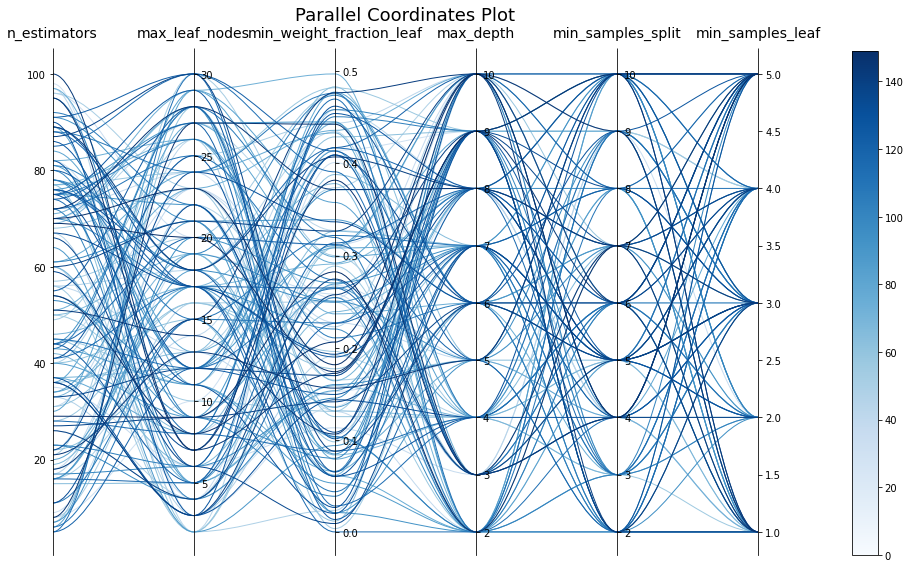

In [37]:
optimizer.plot_parallel_coords(figsize=(14, 8))

In [31]:
model = objective_fn(prefix=f"{PREFIX}{SEP}best", 
                     return_model=True, 
                     fit_on_all_data=True,
                     **optimizer.best_paras())

151 0.86 0.14. Best was 0.86 at 150


In [32]:
model.evaluate(x=TrainX, y=TrainY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.6413602455315053,
 'nse': 0.4794843458903081,
 'rmse': 7583.699842955513}

In [33]:
model.evaluate(x=TestX, y=TestY, metrics=['r2', 'nse', 'rmse'])

{'r2': 0.317546313639448,
 'nse': 0.14404062648484417,
 'rmse': 24225.770265406773}